<a href="https://colab.research.google.com/github/Sumanth-Amballa/CECS_550_SY_Proj/blob/main/EffB3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#This code is used to mount Google Drive to Colab Environment
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Unzip the zip file from Google Drive
!unzip -q "/content/drive/My Drive/archive.zip" -d "/content/resnet50retinadataset"

In [ ]:
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout, BatchNormalization, Conv2D, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import tensorflow as tf

In [ ]:
# Define the path to the dataset
data_path = '/content/resnet50retinadataset/colored_images/'

In [ ]:
!ls "/content/resnet50retinadataset"

colored_images	train.csv


In [ ]:
# Data preprocessing and augmentation
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.25
)

validation_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.efficientnet.preprocess_input, validation_split=0.25)
test_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.efficientnet.preprocess_input)

In [ ]:
# Generator setups
train_generator = train_datagen.flow_from_directory(
    data_path,
    target_size=(300, 300),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = validation_datagen.flow_from_directory(
    data_path,
    target_size=(300, 300),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    data_path,
    target_size=(300, 300),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 2749 images belonging to 5 classes.
Found 913 images belonging to 5 classes.
Found 3662 images belonging to 5 classes.


In [ ]:
# Base model setup
base_model = EfficientNetB3(weights='imagenet', include_top=False, input_tensor=Input(shape=(300, 300, 3)))


43941136/43941136 [==============================] - 0s 0us/step


In [ ]:
# Model architecture
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(5, activation='softmax')(x)

In [ ]:
# Compile the model
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
# Display model architecture
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 300, 300, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 300, 300, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 300, 300, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     (None, 300, 300, 3)          0         ['normalization[0][0]']   

In [ ]:
# Class weights for handling imbalance
labels = train_generator.classes
class_weights = dict(enumerate(compute_class_weight('balanced', classes=np.unique(labels), y=labels)))


In [ ]:
# Model training
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)
]

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=10,  # Increased epochs for potentially better training
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    class_weight=class_weights,
    callbacks=callbacks
)

Epoch 1/10
86/86 [==============================] - 173s 1s/step - loss: 1.8893 - accuracy: 0.4565 - val_loss: 0.9777 - val_accuracy: 0.6265 - lr: 1.0000e-04
Epoch 2/10
86/86 [==============================] - 102s 1s/step - loss: 1.3616 - accuracy: 0.5864 - val_loss: 0.7748 - val_accuracy: 0.7141 - lr: 1.0000e-04
Epoch 3/10
86/86 [==============================] - 107s 1s/step - loss: 1.1290 - accuracy: 0.6501 - val_loss: 0.8120 - val_accuracy: 0.6692 - lr: 1.0000e-04
Epoch 4/10
86/86 [==============================] - 102s 1s/step - loss: 1.0799 - accuracy: 0.6682 - val_loss: 0.8175 - val_accuracy: 0.6375 - lr: 1.0000e-04
Epoch 5/10
86/86 [==============================] - 102s 1s/step - loss: 0.9452 - accuracy: 0.6930 - val_loss: 0.7726 - val_accuracy: 0.6889 - lr: 1.0000e-04
Epoch 6/10
86/86 [==============================] - 108s 1s/step - loss: 0.8395 - accuracy: 0.7254 - val_loss: 0.7328 - val_accuracy: 0.6922 - lr: 1.0000e-04
Epoch 7/10
86/86 [==============================] - 

In [ ]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_generator, steps=len(test_generator))
print(f"Test Accuracy: {test_accuracy*100:.2f}%")


115/115 [==============================] - 26s 221ms/step - loss: 0.3843 - accuracy: 0.8577
Test Accuracy: 85.77%


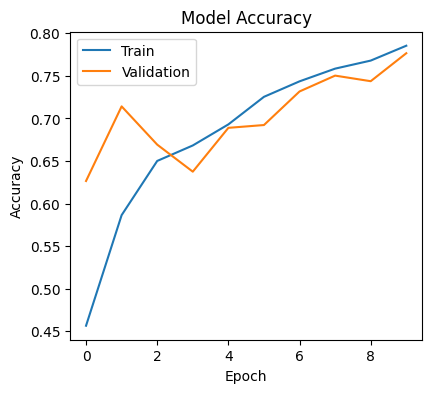

In [ ]:
# Plotting accuracy and loss graphs
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

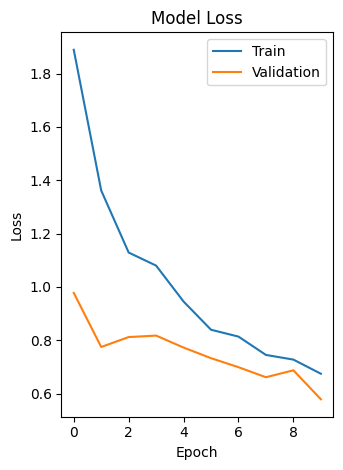

In [ ]:
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Confusion Matrix and Classification Report
predictions = model.predict(test_generator, steps=len(test_generator))
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

115/115 [==============================] - 32s 206ms/step
                precision    recall  f1-score   support

          Mild       0.60      0.82      0.69       370
      Moderate       0.83      0.74      0.78       999
         No_DR       0.98      0.98      0.98      1805
Proliferate_DR       0.73      0.68      0.71       295
        Severe       0.70      0.65      0.67       193

      accuracy                           0.86      3662
     macro avg       0.77      0.78      0.77      3662
  weighted avg       0.87      0.86      0.86      3662



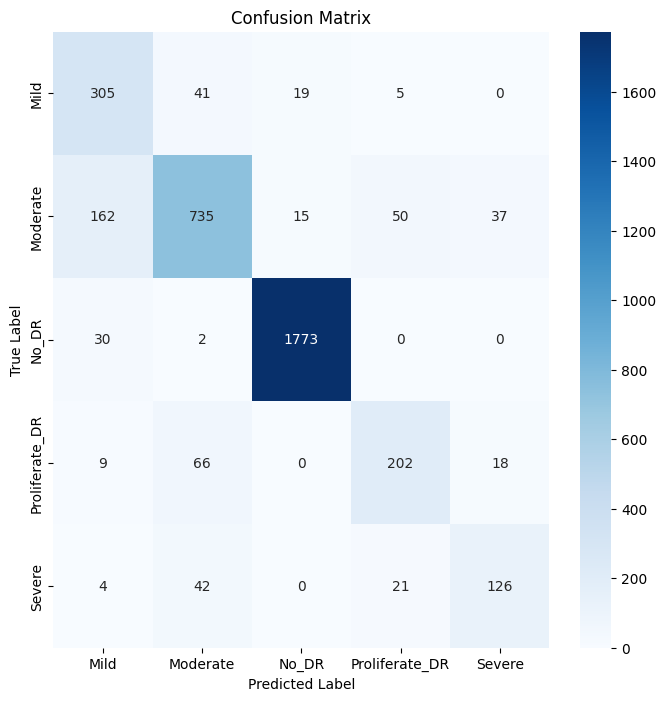

In [ ]:
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [ ]:
f1 = f1_score(true_classes, predicted_classes, average='weighted')
print("F1 Score: {:.2f}".format(f1))

F1 Score: 0.86
